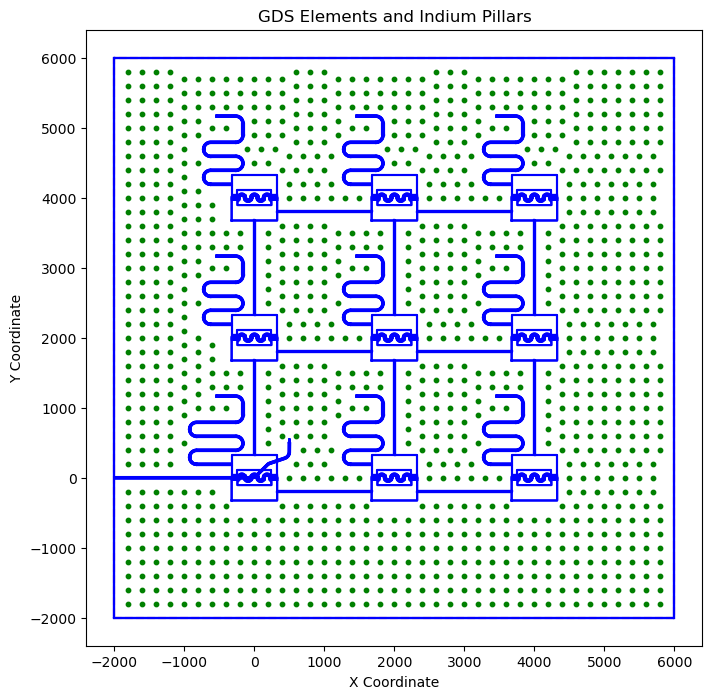

In [1]:
import numpy as np
import gdspy
from shapely.geometry import Polygon, box
import pyclipper
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from addict import Dict

def process_gds_with_indium_optimized(gds_file, coord1, coord2, min_distance_points, min_distance_polygons):
    """
    处理 GDS 文件并布置铟柱，使用 pyclipper 优化距离计算

    输入参数：
    - gds_file: str, GDS 文件路径
    - coord1: tuple, 区域的起始坐标 (x1, y1)
    - coord2: tuple, 区域的结束坐标 (x2, y2)
    - min_distance_points: float, 铟柱之间的最小距离
    - min_distance_polygons: float, 铟柱与多边形之间的最小距离

    返回：
    - 提取的多边形列表
    - 布置的铟柱位置列表
    """
    def extract_elements_optimized(gds_file, coord1, coord2):
        """
        提取 GDS 文件中位于指定矩形区域内的多边形，裁剪区域外部分
        """
        lib = gdspy.GdsLibrary(infile=gds_file)
        x_min, y_min = min(coord1[0], coord2[0]), min(coord1[1], coord2[1])
        x_max, y_max = max(coord1[0], coord2[0]), max(coord1[1], coord2[1])
        region = box(x_min, y_min, x_max, y_max)

        elements = []

        for cell in lib.cells.values():
            for polygon in cell.get_polygons(by_spec=False):
                poly = Polygon(polygon)
                if poly.is_empty:
                    continue

                if poly.intersects(region):
                    clipped = poly.intersection(region)

                    if clipped.is_empty:
                        continue
                    elif clipped.geom_type == 'Polygon':
                        elements.append(np.array(clipped.exterior.coords))
                        for interior in clipped.interiors:
                            elements.append(np.array(interior.coords))
                    elif clipped.geom_type == 'MultiPolygon':
                        for part in clipped.geoms:
                            elements.append(np.array(part.exterior.coords))
                            for interior in part.interiors:
                                elements.append(np.array(interior.coords))

        return elements

    def preprocess_polygons(elements, margin):
        """
        使用 pyclipper 对多边形扩展区域进行预处理，提高点内检查效率
        """
        expanded_polygons = []
        pco = pyclipper.PyclipperOffset()

        for element in elements:
            pco.Clear()
            pco.AddPath(element.tolist(), pyclipper.JT_ROUND, pyclipper.ET_CLOSEDPOLYGON)
            expanded = pco.Execute(margin)
            expanded_polygons.extend(expanded)

        return expanded_polygons

    def point_inside_polygons(point, expanded_polygons):
        """
        快速检查点是否在扩展多边形内
        """
        for poly in expanded_polygons:
            if pyclipper.PointInPolygon(point, poly) != 0:
                return True
        return False

    def optimized_distance_check(point, tree, expanded_polygons, min_distance_points):
        if tree and tree.query(point, k=1)[0] < min_distance_points:
            return False
        if point_inside_polygons(point, expanded_polygons):
            return False
        return True

    def add_indium(elements, coord1, coord2, step=100, min_distance_points=200, min_distance_polygons=20):
        x_min, y_min = min(coord1[0], coord2[0]), min(coord1[1], coord2[1])
        x_max, y_max = max(coord1[0], coord2[0]), max(coord1[1], coord2[1])

        grid_x = np.arange(x_min, x_max, step)
        grid_y = np.arange(y_min, y_max, step)

        indium_points = []
        tree = None

        expanded_polygons = preprocess_polygons(elements, min_distance_polygons)

        for x in grid_x:
            for y in grid_y:
                point = (x, y)
                if optimized_distance_check(point, tree, expanded_polygons, min_distance_points):
                    indium_points.append(point)
                    tree = KDTree(indium_points)

        return indium_points

    def plot_elements_and_indium(coord1, coord2, elements, indium_points):
        fig, ax = plt.subplots(figsize=(10, 8))

        rect_x = [coord1[0], coord2[0], coord2[0], coord1[0], coord1[0]]
        rect_y = [coord1[1], coord1[1], coord2[1], coord2[1], coord1[1]]
        ax.plot(rect_x, rect_y, 'r--', label="Bounding Box")

        for polygon in elements:
            polygon = np.array(polygon)
            ax.plot(polygon[:, 0], polygon[:, 1], 'b-')

        if indium_points:
            indium_x, indium_y = zip(*indium_points)
            ax.scatter(indium_x, indium_y, color='g', s=10)

        ax.set_xlabel("X Coordinate")
        ax.set_ylabel("Y Coordinate")
        ax.set_aspect('equal', 'box')
        plt.title("GDS Elements and Indium Pillars")
        plt.show()

    elements = extract_elements_optimized(gds_file, coord1, coord2)
    indium_pillars = add_indium(elements, coord1, coord2, step=100, 
                                min_distance_points=min_distance_points, 
                                min_distance_polygons=min_distance_polygons)
    plot_elements_and_indium(coord1, coord2, elements, indium_pillars)

    def return_indium_options(indium_positions):
        options=Dict()
        for pos in indium_positions:
            option=Dict(
                # 框架
                name = f"In_{pos}",
                type = "IndiumBump",
                chip = "chip0",
                outline = [],
                # 几何参数
                center_pos = pos,
                radius = 10
            )
            options[option.name]=option
        return options
    
    options = return_indium_options(indium_pillars)

    return options

# 示例调用
gds_file = "./for_auto_gene_indium.gds"
coord1 = (-2000, -2000)
coord2 = (6000, 6000)
min_distance_points = 200
min_distance_polygons = 100

# 处理 GDS 文件
options = process_gds_with_indium_optimized(
    gds_file, coord1, coord2, min_distance_points, min_distance_polygons)

# def return_indium_options():
#     options=Dict()
#     for pos in indium_positions:
#         option=Dict(
#             # 框架
#             name = f"In_{pos}",
#             type = "IndiumBump",
#             chip = "chip0",
#             outline = [],
#             # 几何参数
#             center_pos = pos,
#             radius = 10
#         )
#         options[option.name]=option
#     return options
# options = return_indium_options()